# ARBOx 2025 - Circuit Tracing Reproduction

### **Oru Ogbo & Declan McKenna**

This notebook serves aims to reproduce some of Anthropic's work and accompanying tutorial for the circuit tracing library. The circuit tracing library was built by [Anthropic Fellows](https://www.anthropic.com/research/open-source-circuit-tracing) to enable users explain model behavior by generating Attribution Graphs (introduced in [Circuit Tracing](https://transformer-circuits.pub/2025/attribution-graphs/methods.html)), and validate these explanations with experiments.

**In this notebook we aim to replicate some of Anthropic's findings on multi-step reasoning circuits using our own graph and examples generated on [Neuronpedia](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-dallas-austin&pruningThreshold=0.6&pinnedIds=27_22605_10%2C20_15589_10%2CE_26865_9%2C21_5943_10%2C23_12237_10%2C20_15589_9%2C16_25_9%2C14_2268_9%2C18_8959_10%2C4_13154_9%2C7_6861_9%2C19_1445_10%2CE_2329_7%2CE_6037_4%2C0_13727_7%2C6_4012_7%2C17_7178_10%2C15_4494_4%2C6_4662_4%2C4_7671_4%2C3_13984_4%2C1_1000_4%2C19_7477_9%2C18_6101_10%2C16_4298_10%2C7_691_10&supernodes=%5B%5B%22capital%22%2C%2215_4494_4%22%2C%226_4662_4%22%2C%224_7671_4%22%2C%223_13984_4%22%2C%221_1000_4%22%5D%2C%5B%22state%22%2C%226_4012_7%22%2C%220_13727_7%22%5D%2C%5B%22Texas%22%2C%2220_15589_9%22%2C%2219_7477_9%22%2C%2216_25_9%22%2C%224_13154_9%22%2C%2214_2268_9%22%2C%227_6861_9%22%5D%2C%5B%22preposition+followed+by+place+name%22%2C%2219_1445_10%22%2C%2218_6101_10%22%5D%2C%5B%22capital+cities+%2F+say+a+capital+city%22%2C%2221_5943_10%22%2C%2217_7178_10%22%2C%227_691_10%22%2C%2216_4298_10%22%5D%5D&densityThreshold=0.99&clerps=%5B%5B%2223_2312237_10%22%2C%22Cities+and+states+names+%28say+Austin%29%22%5D%2C%5B%2218_1808959_10%22%2C%22state+%2F+regional+government%22%5D%5D)**.

We make use of attribution graphs generated using Gemma 2 (2B), and base our Multi-Step Reasoning experiments on examples [in the original paper](https://transformer-circuits.pub/2025/attribution-graphs/biology.html). We have modified the example to examine the new graphs to prove (or disprove) that multi-step reasoning occurs in similar ways on different problems. 

We'll view the graphs, annotated with labeled supernodes, and then perform interventions to verify that the supernodes' labels are indeed correct, and that interventions have the effect we expect. 

In [1]:
#@title Colab Setup Environment

try:
    import google.colab
    !mkdir -p repository && cd repository && \
     git clone https://github.com/safety-research/circuit-tracer && \
     curl -LsSf https://astral.sh/uv/install.sh | sh && \
     uv pip install -e circuit-tracer/

    import sys
    from huggingface_hub import notebook_login
    sys.path.append('repository/circuit-tracer')
    sys.path.append('repository/circuit-tracer/demos')
    notebook_login(new_session=False)
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [3]:
from collections import namedtuple
from typing import List, Dict

import torch

from circuit_tracer import ReplacementModel
from utils import extract_supernode_features

model = ReplacementModel.from_pretrained("google/gemma-2-2b", 'gemma', dtype=torch.bfloat16)

Fetching 26 files: 100%|██████████| 26/26 [00:00<00:00, 169.98it/s]


Loading checkpoint shards: 100%|██████████| 3/3 [00:12<00:00,  4.26s/it]


Loaded pretrained model google/gemma-2-2b into HookedTransformer


# Two-hop reasoning
We'll start with the example [`Fact: The capital of the country containing the pyramids of Giza is -> Cairo`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-dallas-austin&pruningThreshold=0.6&pinnedIds=27_22605_10%2C20_15589_10%2CE_26865_9%2C21_5943_10%2C23_12237_10%2C20_15589_9%2C16_25_9%2C14_2268_9%2C18_8959_10%2C4_13154_9%2C7_6861_9%2C19_1445_10%2CE_2329_7%2CE_6037_4%2C0_13727_7%2C6_4012_7%2C17_7178_10%2C15_4494_4%2C6_4662_4%2C4_7671_4%2C3_13984_4%2C1_1000_4%2C19_7477_9%2C18_6101_10%2C16_4298_10%2C7_691_10&supernodes=%5B%5B%22capital%22%2C%2215_4494_4%22%2C%226_4662_4%22%2C%224_7671_4%22%2C%223_13984_4%22%2C%221_1000_4%22%5D%2C%5B%22state%22%2C%226_4012_7%22%2C%220_13727_7%22%5D%2C%5B%22Texas%22%2C%2220_15589_9%22%2C%2219_7477_9%22%2C%2216_25_9%22%2C%224_13154_9%22%2C%2214_2268_9%22%2C%227_6861_9%22%5D%2C%5B%22preposition+followed+by+place+name%22%2C%2219_1445_10%22%2C%2218_6101_10%22%5D%2C%5B%22capital+cities+%2F+say+a+capital+city%22%2C%2221_5943_10%22%2C%2217_7178_10%22%2C%227_691_10%22%2C%2216_4298_10%22%5D%5D&densityThreshold=0.99&clerps=%5B%5B%2223_2312237_10%22%2C%22Cities+and+states+names+%28say+Austin%29%22%5D%2C%5B%2218_1808959_10%22%2C%22state+%2F+regional+government%22%5D%5D), which requires two hop-reasoning. The model must first reason that the country containing the pyramids of Giza is Egypt; then, it must respond with the capital of Egypt, Cairo.



### Original Paper and Implementation on Gemma-2B

[The original paper](https://transformer-circuits.pub/2025/attribution-graphs/biology.html#dives-tracing) showed that Haiku solves a similar problem using the following circuit, computing the intermediate step of the state containing Dallas: Texas.

<img src="https://raw.githubusercontent.com/safety-research/circuit-tracer/main/demos/img/dallas-austin-haiku.png" width="300" />

Performing attribution on Gemma 2 (2B) shows that it uses [this circuit](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-dallas-austin&pruningThreshold=0.6&pinnedIds=27_22605_10%2C20_15589_10%2CE_26865_9%2C21_5943_10%2C23_12237_10%2C20_15589_9%2C16_25_9%2C14_2268_9%2C18_8959_10%2C4_13154_9%2C7_6861_9%2C19_1445_10%2CE_2329_7%2CE_6037_4%2C0_13727_7%2C6_4012_7%2C17_7178_10%2C15_4494_4%2C6_4662_4%2C4_7671_4%2C3_13984_4%2C1_1000_4%2C19_7477_9%2C18_6101_10%2C16_4298_10%2C7_691_10&supernodes=%5B%5B%22capital%22%2C%2215_4494_4%22%2C%226_4662_4%22%2C%224_7671_4%22%2C%223_13984_4%22%2C%221_1000_4%22%5D%2C%5B%22state%22%2C%226_4012_7%22%2C%220_13727_7%22%5D%2C%5B%22Texas%22%2C%2220_15589_9%22%2C%2219_7477_9%22%2C%2216_25_9%22%2C%224_13154_9%22%2C%2214_2268_9%22%2C%227_6861_9%22%5D%2C%5B%22preposition+followed+by+place+name%22%2C%2219_1445_10%22%2C%2218_6101_10%22%5D%2C%5B%22capital+cities+%2F+say+a+capital+city%22%2C%2221_5943_10%22%2C%2217_7178_10%22%2C%227_691_10%22%2C%2216_4298_10%22%5D%5D&densityThreshold=0.99&clerps=%5B%5B%2223_2312237_10%22%2C%22Cities+and+states+names+%28say+Austin%29%22%5D%2C%5B%2218_1808959_10%22%2C%22state+%2F+regional+government%22%5D%5D) to successfully complete the prompt:

<img src="https://raw.githubusercontent.com/safety-research/circuit-tracer/main/demos/img/gemma/dallas-austin-new.png" width="600" />

The circuit is similar: it has a node corresponding to Texas, and shows both a direct path from Dallas to Austin as well as an indirect path going through Texas. The Attribution Graph suggests a hypothesis about model behavior, based on using transcoders to approximate the behavior of MLPs. We can verify that our understanding of model behavior is correct by performing interventions directly on the underlying model.

### Our implementation

We'll develop a similar circuit, identify supernodes then perform interventions on each of the supernodes. So, we will first identify and get the supernodes from our graph. We have a convenience function that will map a circuit URL (and the supernodes stored therein), to a list of Feature objects; each Feature is a tuple of `(layer, position, feature_index)`.

In [4]:
cairo_url="https://www.neuronpedia.org/gemma-2-2b/graph?slug=two-step-pyramids&pruningThreshold=0.61&densityThreshold=0.99&pinnedIds=18_886_14%2C21_5943_14%2CE_129557_10%2C20_3909_14%2C14_8796_13%2CE_6037_4%2CE_3170_7%2C20_5916_14%2C19_1771_14%2CE_8667_13%2C27_53731_14%2C20_9516_14%2C21_2945_14%2C18_886_13%2CE_653_12%2C19_14947_14%2C18_886_10%2C6_7546_13%2C14_8796_10%2C4_664_10%2C7_10133_13%2C6_7546_10%2C4_3950_10%2C0_3512_10%2C4_7671_5%2C18_886_14%2C8_8454_10%2C4_7356_13%2C7_14467_13%2C4_11171_13%2C4_3950_13%2C18_6101_14%2C19_2695_14%2C4_6087_7%2C2_7173_4%2C6_4662_4%2C2_13756_7&supernodes=%5B%5B%22Egypt%22%2C%2225_4906_14%22%2C%2221_2945_14%22%2C%2218_886_10%22%2C%2218_886_13%22%2C%2218_886_14%22%5D%2C%5B%22history%22%2C%224_7356_13%22%2C%224_11171_13%22%2C%224_3950_13%22%2C%220_3512_10%22%2C%227_10133_13%22%2C%224_3950_10%22%2C%228_8454_10%22%5D%2C%5B%22middle+east%22%2C%226_7546_10%22%2C%226_7546_13%22%2C%224_664_10%22%2C%224_664_13%22%2C%2220_3909_14%22%2C%2214_8796_13%22%2C%2214_8796_10%22%2C%227_14467_13%22%5D%2C%5B%22say+cairo%22%2C%2221_10336_14%22%2C%2221_5943_14%22%5D%2C%5B%22say+a+capital%22%2C%224_7671_5%22%2C%2219_2695_14%22%2C%2218_6101_14%22%2C%2219_14947_14%22%2C%2220_5916_14%22%2C%226_4662_4%22%2C%222_7173_4%22%5D%2C%5B%22country%22%2C%222_13756_7%22%2C%2220_9516_14%22%2C%2219_1771_14%22%2C%224_6087_7%22%5D%5D"
supernode_features = extract_supernode_features(cairo_url)

We'll then create a representation of the circuit being used to solve this task. This means defining some Supernode objects, which will store a list of underlying features, as well as their children supernodes that they have a causal effect on.

In [ ]:
from graph_visualization import create_graph_visualization, Supernode, InterventionGraph, Feature

# Supernodes that upweight certain outputs. Note that e.g. the Say Austin node is not the only node promoting Austin, but that is its primary role
say_cairo_node = Supernode(name='Say cairo', features=[Feature(layer=21, pos=14, feature_idx=5943)])
say_capital_node = Supernode(name='Say a capital', features=supernode_features['say a capital'], children=[say_cairo_node])
egypt_node = Supernode(name='Egypt', features=supernode_features['Egypt'], children=[say_cairo_node])
country_node = Supernode(name='Country', features=supernode_features['country'], children=[say_capital_node])
middle_east_node = Supernode(name='Middle East', features=supernode_features['middle east'], children=[egypt_node])
history_node = Supernode(name='History', features=supernode_features['history'], children=[middle_east_node])

# Embedding nodes
pyramids_emb_node = Supernode(name='Emb: pyramids', features=None, children=[history_node, egypt_node])
iza_emb_node = Supernode(name='Emb: iza', features=None, children=[history_node, middle_east_node])
g_emb_node = Supernode(name='Emb: G', features=None, children=[iza_emb_node])
country_emb_node = Supernode(name='Emb: country', features=None, children=[country_node])
capital_emb_node = Supernode(name='Emb: capital', features=None, children=[say_capital_node])

We then initialize an InterventionGraph, which stores all of our Supernodes, and keeps track of their state. We'll also get the model's logits and activations on this prompt. We then set each node's default activation (its activation on the original prompt, without interventions), and set its activation fraction. The activation fraction is the node's current activation / its default activation. Since the current and default activations are the same, each node is at 100%

In [ ]:
prompt = "Fact: The capital of the country containing the pyramids of Giza is"
ordered_nodes = [[capital_emb_node, country_emb_node, pyramids_emb_node, iza_emb_node, g_emb_node],[country_node, history_node],[say_capital_node, egypt_node, middle_east_node], [say_cairo_node]]
cairo_pyramids_graph = InterventionGraph(ordered_nodes=ordered_nodes, prompt=prompt)

logits, cairo_activations = model.get_activations(prompt)

for node in [say_cairo_node, say_capital_node, egypt_node, country_node, middle_east_node, history_node]:
    cairo_pyramids_graph.initialize_node(node, cairo_activations)  

cairo_pyramids_graph.set_node_activation_fractions(cairo_activations)

We'll record the top-7 logits as well, and then visualize our graph! (Unlike 5 logits in the original implementation); a target for experimentation is "Egypt" which has just a 3% output probability.

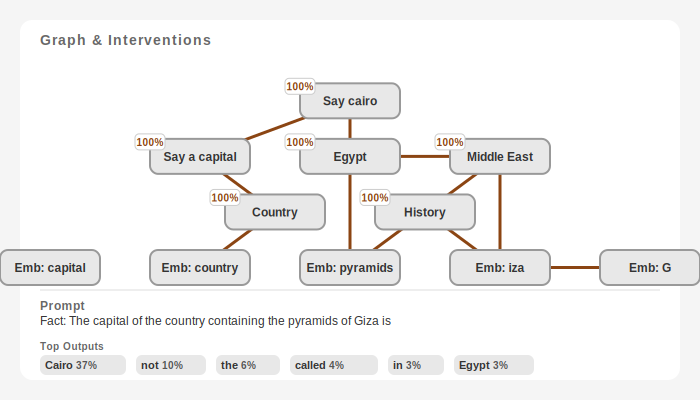

In [7]:
def get_top_outputs(logits: torch.Tensor, k: int = 7):
    top_probs, top_token_ids = logits.squeeze(0)[-1].softmax(-1).topk(k)
    top_tokens = [model.tokenizer.decode(token_id) for token_id in top_token_ids]
    top_outputs = list(zip(top_tokens, top_probs.tolist()))
    return top_outputs

top_outputs = get_top_outputs(logits)

create_graph_visualization(cairo_pyramids_graph, top_outputs)

The displayed circuit is consistent with the supernodes we created when visualizing the full graph. We'll now verify that each supernode plays the role we hypothesized using interventions. Each intervention will set a node's value to some multiple of its original value.

In [ ]:
Intervention = namedtuple('Intervention', ['supernode', 'scaling_factor'])
def supernode_intervention(intervention_graph: InterventionGraph, interventions: List[Intervention], replacements: Dict[str, Supernode] = None):
    intervention_values = [(*feature, scaling_factor * default_act) for intervened_supernode, scaling_factor in interventions 
                           for feature, default_act in zip(intervened_supernode.features, intervened_supernode.default_activations)]
    new_logits, new_activations = model.feature_intervention(intervention_graph.prompt, intervention_values)
    intervention_graph.set_node_activation_fractions(new_activations)
    top_outputs = get_top_outputs(new_logits)

    for intervened_supernode, scaling_factor in interventions:
        intervened_supernode.activation = None
        intervened_supernode.intervention = f'{scaling_factor}x'

    if replacements is not None:
        for target, replacement in replacements.items():
            intervention_graph.nodes[target].replacement_node = replacement

    return create_graph_visualization(intervention_graph, top_outputs)

In the original paper, turning off the "Say a capital" feature caused the "Say Austin" supernode to shut off, and the model's top logit to change to Texas.

**We retest this on our prompt and attribution graph** - We turn off the "Say a Capital" supernode.

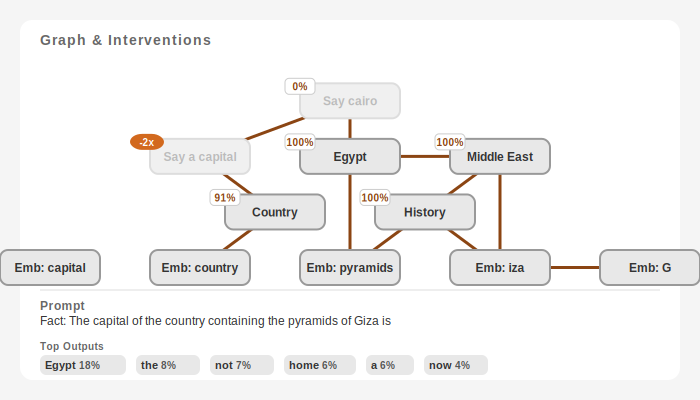

In [9]:
supernode_intervention(cairo_pyramids_graph, [Intervention(say_capital_node, -2)])

We observe precisely the same behavior! Strongly shutting off the "Say a capital" supernode turned off the "Say Cairo" node, and changed the top logit to Egypt. 

What if we turn off the "Country" supernode?

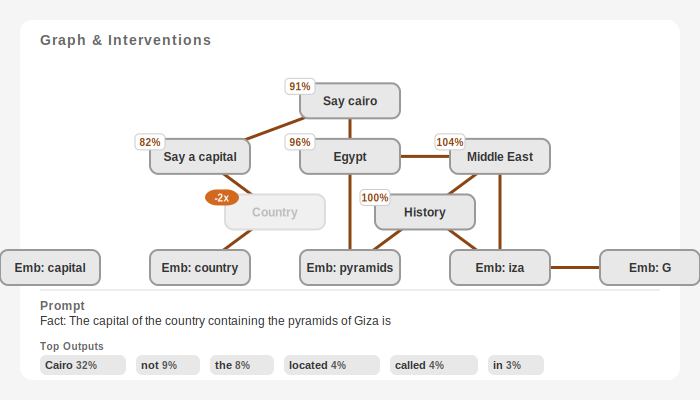

In [10]:
supernode_intervention(cairo_pyramids_graph, [Intervention(country_node, -2)])

Turning off the "Country" supernode is ineffective. There is only a minor reduction in the probability of the model producing Cairo.

What if we turn off the Egypt supernode?

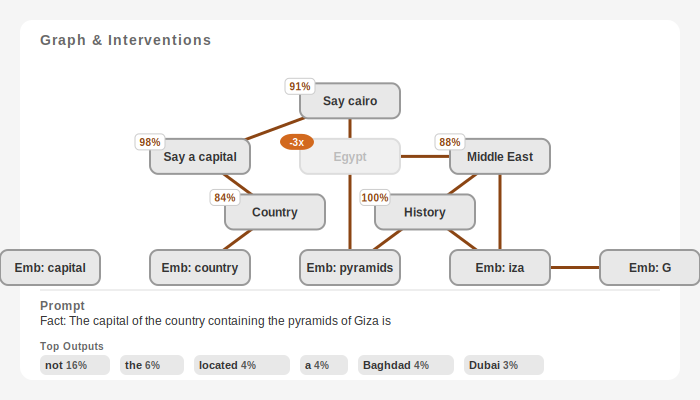

In [71]:
supernode_intervention(cairo_pyramids_graph, [Intervention(egypt_node, -3)])

Turning off the "Egypt" supernode (-2x) reduces the likelihood of outputting Cairo, but does not completely eliminate the possibility. The most likely output is now "not", and capitals of other middle-eastern countries now have an increased probability of being generated e.g. "Baghad".

Strongly turning off the "Egypt" supernode (-3x) almost completely eliminates the possibility of outputting Cairo, with Baghdad and Dubai now more likely cities to be generated.

What if we turn off the "history" supernode?

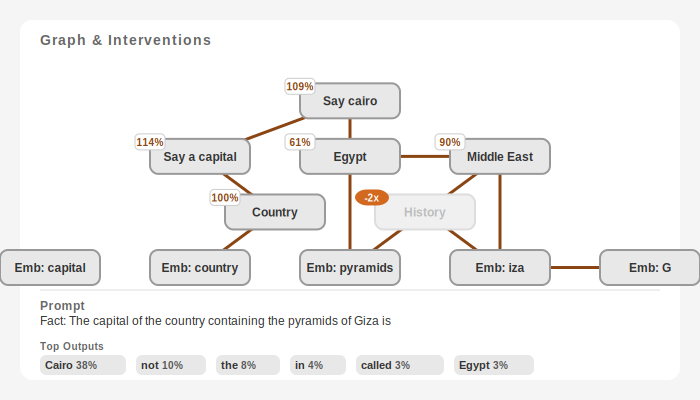

In [75]:
supernode_intervention(cairo_pyramids_graph, [Intervention(history_node, -2)])

Turning off the "history" supernode was entirely ineffectual. There was no change to the likelihood of producing Cairo as the final logit.

What if we turn off the "Middle East" supernode?

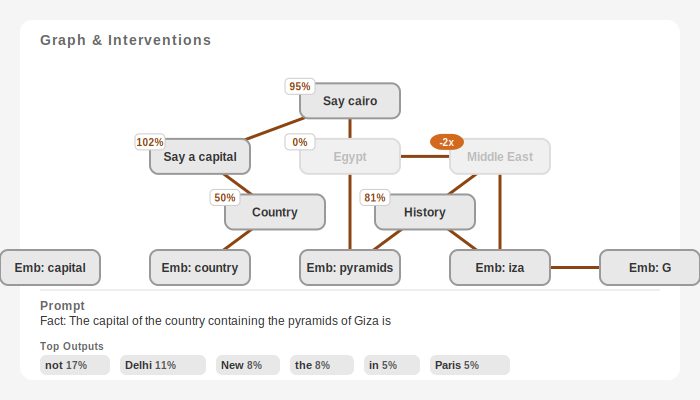

In [119]:
supernode_intervention(cairo_pyramids_graph, [Intervention(middle_east_node, -2)])

Surprisingly, **turning off the "Middle East" supernode was very effective,** the top logits now include "not", "Delhi", "New" and "Paris". Cairo is unlikely to be generated!

We’ve validated the behavior of nodes by ablating them. Could we inject entirely different nodes and validate that they have the expected effect? 

Take the circuit from the prompt [`Fact: The capital of the country containing the Colosseum is` → `Rome`]((https://www.neuronpedia.org/gemma-2-2b/graph?slug=two-step-rome&pruningThreshold=0.6&densityThreshold=0.99&pinnedIds=E_170875_11%2C20_7666_12%2C17_8341_11%2C19_14947_12%2C27_11344_12%2C21_5943_12%2C20_4402_12%2C19_2695_12%2C18_6101_12%2C17_7178_12%2C19_1233_12%2CE_6037_4%2C6_4662_4%2CE_1911_10%2CE_3170_7%2C4_6087_7%2C3_14009_7%2C0_8918_7%2C0_3331_4%2C20_7666_11%2C4_5749_11%2C4_6637_11%2C5_8288_11%2C5_3951_11%2C6_14038_11%2C6_15096_11%2C8_7882_11%2C8_8454_11%2C16_4298_12%2C16_5021_12%2C17_1084_12%2C18_3781_12%2C19_5100_12%2C15_4494_4%2C14_7317_11%2C14_11156_11%2C8_1527_11%2C7_15891_11%2C7_13812_11%2CE_18143_1%2C4_7671_4&supernodes=%5B%5B%22say+rome%22%2C%2223_141_12%22%2C%2221_5943_12%22%5D%2C%5B%22country%22%2C%223_14009_7%22%2C%220_8918_7%22%2C%224_6087_7%22%5D%2C%5B%22history%22%2C%2214_11156_11%22%2C%227_15891_11%22%2C%225_3951_11%22%2C%2219_1233_12%22%2C%2220_4402_12%22%2C%228_7882_11%22%2C%228_8454_11%22%2C%225_8288_11%22%2C%224_5749_11%22%5D%2C%5B%22Italy%22%2C%2214_7317_11%22%2C%228_1527_11%22%2C%227_13812_11%22%2C%2217_8341_11%22%2C%2219_5100_12%22%2C%2218_3781_12%22%2C%2220_7666_11%22%2C%226_14038_11%22%2C%226_15096_11%22%2C%224_6637_11%22%2C%2220_7666_12%22%5D%2C%5B%22say+a+capital%22%2C%224_7671_4%22%2C%2215_4494_4%22%2C%220_3331_4%22%2C%2216_5021_12%22%2C%2218_6101_12%22%2C%2219_2695_12%22%2C%2217_1084_12%22%2C%2219_14947_12%22%2C%2216_4298_12%22%2C%226_4662_4%22%2C%2217_7178_12%22%5D%5D)). We'll add two supernodes from this graph—"Italy" and "Say Rome" to our InterventionGraph.

In [14]:
rome_prompt = "Fact: the capital of the country containing the Colosseum is"
rome_logits, rome_activations = model.get_activations(rome_prompt)

rome_url = "https://www.neuronpedia.org/gemma-2-2b/graph?slug=two-step-rome&pruningThreshold=0.6&densityThreshold=0.99&pinnedIds=E_170875_11%2C20_7666_12%2C17_8341_11%2C19_14947_12%2C27_11344_12%2C20_4402_12%2C19_2695_12%2C18_6101_12%2C17_7178_12%2C19_1233_12%2CE_6037_4%2C6_4662_4%2CE_1911_10%2CE_3170_7%2C4_6087_7%2C3_14009_7%2C0_8918_7%2C0_3331_4%2C20_7666_11%2C4_5749_11%2C4_6637_11%2C5_8288_11%2C5_3951_11%2C6_14038_11%2C6_15096_11%2C8_7882_11%2C8_8454_11%2C16_4298_12%2C16_5021_12%2C17_1084_12%2C18_3781_12%2C19_5100_12%2C15_4494_4%2C14_7317_11%2C14_11156_11%2C8_1527_11%2C7_15891_11%2C7_13812_11%2CE_18143_1%2C4_7671_4%2C24_9382_12%2C21_5943_12%2C21_11272_11%2C20_4402_11%2C19_1233_11%2C21_12427_12&supernodes=%5B%5B%22country%22%2C%223_14009_7%22%2C%220_8918_7%22%2C%224_6087_7%22%5D%2C%5B%22say+rome%22%2C%220_24_12%22%2C%2224_9382_12%22%5D%2C%5B%22say+a+capital%22%2C%2221_5943_12%22%2C%224_7671_4%22%2C%2215_4494_4%22%2C%220_3331_4%22%2C%2216_5021_12%22%2C%2218_6101_12%22%2C%2219_2695_12%22%2C%2217_1084_12%22%2C%2219_14947_12%22%2C%2216_4298_12%22%2C%226_4662_4%22%2C%2217_7178_12%22%5D%2C%5B%22roman+history%22%2C%2219_1233_11%22%2C%2220_4402_11%22%2C%2214_11156_11%22%2C%227_15891_11%22%2C%225_3951_11%22%2C%2219_1233_12%22%2C%2220_4402_12%22%2C%228_7882_11%22%2C%228_8454_11%22%2C%225_8288_11%22%2C%224_5749_11%22%5D%2C%5B%22Italy%22%2C%2221_12427_12%22%2C%2221_11272_11%22%2C%2214_7317_11%22%2C%228_1527_11%22%2C%227_13812_11%22%2C%2217_8341_11%22%2C%2219_5100_12%22%2C%2218_3781_12%22%2C%2220_7666_11%22%2C%226_14038_11%22%2C%226_15096_11%22%2C%224_6637_11%22%2C%2220_7666_12%22%5D%5D"
rome_supernodes = extract_supernode_features(rome_url)

say_rome_node = Supernode('Say Rome', features=[Feature(layer=24, pos=12, feature_idx=9382)])
italy_node = Supernode('Italy', features=rome_supernodes['Italy'], children=[say_rome_node])
roman_history_node = Supernode("Roman History", features=rome_supernodes['roman history'], children=[italy_node])
roman_capital_node = Supernode("Say a Capital (Roman)", features=rome_supernodes['say a capital'], children=[say_rome_node])
roman_country_node = Supernode("Country (Roman)", features=rome_supernodes['country'], children=[italy_node])

for node in [say_rome_node, italy_node, roman_history_node, roman_capital_node, roman_country_node]:
    cairo_pyramids_graph.initialize_node(node, rome_activations)

Then, we'll perform an intervention, turning off the "Egypt" supernode and turning on the "Italy" supernode.

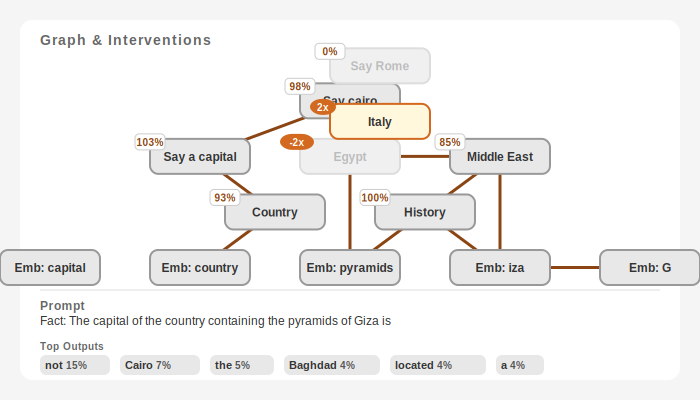

In [77]:
rome_interventions = [Intervention(egypt_node, -2), Intervention(italy_node, 2)]
supernode_intervention(cairo_pyramids_graph, rome_interventions, {egypt_node.name: italy_node, say_cairo_node.name: say_rome_node})

Doing this has some negative effect on the "Say Cairo" node, but does not activate the "Say Rome" node. The top logit is now "not", but Cairo is still the second most likely logit.

What will happen if instead we replaced the "Middle East" with "Roman History", and "Egypt" with "Italy?

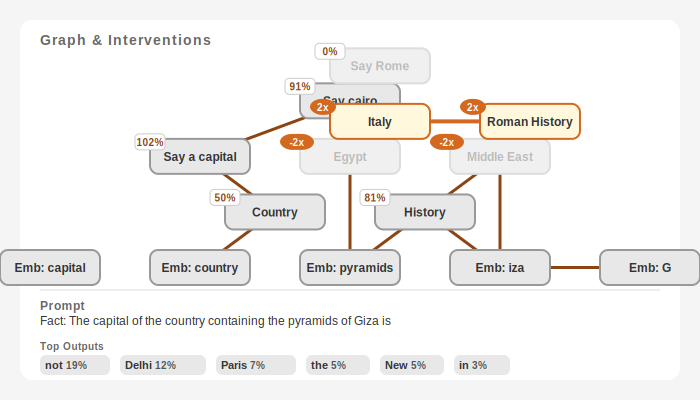

In [80]:
rome_interventions = [Intervention(egypt_node, -2), Intervention(middle_east_node, -2), Intervention(roman_history_node, 2), Intervention(italy_node, 2)]
supernode_intervention(cairo_pyramids_graph, rome_interventions, {middle_east_node.name: roman_history_node, say_cairo_node.name: say_rome_node, egypt_node.name: italy_node})

We get similar logits to ablating out "Middle East", but no substantial increase to the probability of generating Rome as an output.

We suspect some information is being passed through other parts of the circuit, namely through the "Country" supernode. To test this hypothesis, we considered replacing with countries.

Take the circuit for [`Fact: The capital of the country containing Shanghai is` → `Beijing`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-shanghai-beijing&clerps=%5B%5D&clickedId=15_4494_4&pruningThreshold=0.45&pinnedIds=27_33395_10%2CE_38628_9%2C21_5943_10%2C19_12274_10%2C19_12274_9%2C14_12274_9%2C18_6101_10%2C17_7178_10%2C6_6811_9%2C4_4257_9%2C4_11570_9%2CE_6037_4%2C0_8885_4%2C18_7639_10%2C19_2695_10%2C16_4298_10%2C15_4494_4%2C6_4662_4&supernodes=%5B%5B%22China%22%2C%2219_12274_9%22%2C%2214_12274_9%22%2C%226_6811_9%22%2C%224_11570_9%22%2C%224_4257_9%22%5D%2C%5B%22China%22%2C%2219_12274_10%22%2C%2218_7639_10%22%5D%2C%5B%22capital%22%2C%2216_4298_10%22%2C%2217_7178_10%22%2C%2218_6101_10%22%2C%2219_2695_10%22%2C%2221_5943_10%22%5D%2C%5B%22capital+cities+%28say+city%29%22%2C%226_4662_4%22%2C%2215_4494_4%22%2C%220_8885_4%22%5D%5D). We'll do precisely what we did before, disabling the "Egypt" and "Middle East" supernodes and activating the China supernode. 

This time, there is no "Say Beijing" node, but the effect of this intervention should be visible in the logits.

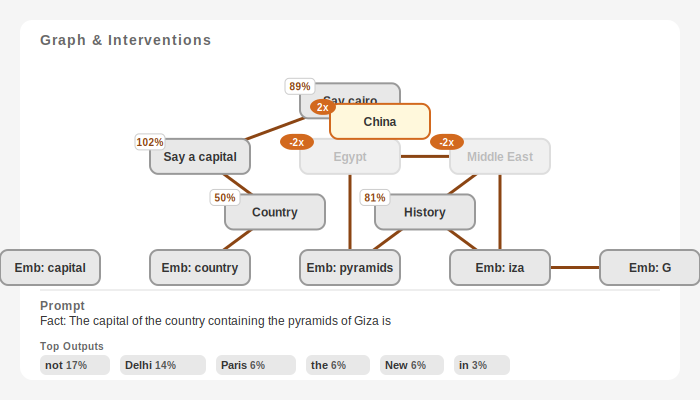

In [29]:
shanghai_prompt = "Fact: the capital of the country containing Shanghai is"
_, shanghai_activations = model.get_activations(shanghai_prompt)

shanghai_url = "https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-shanghai-beijing&clerps=%5B%5D&clickedId=15_4494_4&pruningThreshold=0.45&pinnedIds=27_33395_10%2CE_38628_9%2C21_5943_10%2C19_12274_10%2C19_12274_9%2C14_12274_9%2C18_6101_10%2C17_7178_10%2C6_6811_9%2C4_4257_9%2C4_11570_9%2CE_6037_4%2C0_8885_4%2C18_7639_10%2C19_2695_10%2C16_4298_10%2C15_4494_4%2C6_4662_4&supernodes=%5B%5B%22China%22%2C%2219_12274_9%22%2C%2214_12274_9%22%2C%226_6811_9%22%2C%224_11570_9%22%2C%224_4257_9%22%5D%2C%5B%22China%22%2C%2219_12274_10%22%2C%2218_7639_10%22%5D%2C%5B%22capital%22%2C%2216_4298_10%22%2C%2217_7178_10%22%2C%2218_6101_10%22%2C%2219_2695_10%22%2C%2221_5943_10%22%5D%2C%5B%22capital+cities+%28say+city%29%22%2C%226_4662_4%22%2C%2215_4494_4%22%2C%220_8885_4%22%5D%5D"
shanghai_supernodes = extract_supernode_features(shanghai_url)

china_node = Supernode('China', features=shanghai_supernodes['China'] + shanghai_supernodes['China (2)'])#, 

for node in [china_node]:
    cairo_pyramids_graph.initialize_node(node, shanghai_activations)

china_interventions = [Intervention(egypt_node, -2), Intervention(middle_east_node, -2), Intervention(china_node, 2)]
supernode_intervention(cairo_pyramids_graph, china_interventions, {egypt_node.name: china_node})

Similarly, this doesn't work; the model has the same outputs as ablating the "Middle East" supernode. The model seems to want to generate either "New Delhi" or "Paris"

Does this always work? Let's try with the circuit for [`Fact: the capital of the country containing Cancun is` → `Mexico`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=two-step-cancun&pruningThreshold=0.55&densityThreshold=0.99&pinnedIds=15_4494_4%2C27_11198_10%2CE_6037_4%2C0_5660_4%2C6_4662_4%2C19_6810_9%2C17_14871_9%2CE_173403_9%2C4_67_9%2C8_5119_9%2C6_5150_9%2C19_6810_10%2C14_10090_9%2C15_11083_9%2C7_6861_9%2CE_3170_7%2C4_6087_7%2C0_8918_7%2C0_15423_7%2C14_2268_9&supernodes=%5B%5B%22capital+cities%22%2C%220_5660_4%22%2C%2215_4494_4%22%2C%226_4662_4%22%5D%2C%5B%22mexico%22%2C%2219_6810_9%22%2C%2217_14871_9%22%2C%2219_6810_10%22%5D%2C%5B%22mexico%22%2C%2215_11083_9%22%2C%226_5150_9%22%2C%224_67_9%22%2C%228_5119_9%22%2C%2214_10090_9%22%5D%2C%5B%22country%22%2C%220_8918_7%22%2C%224_6087_7%22%2C%220_15423_7%22%5D%2C%5B%22mentions+of+Texas%22%2C%2214_2268_9%22%2C%227_6861_9%22%5D%5D). 

In [30]:
mexico_prompt = "Fact: the capital of the country containing Cancun is"
_, mexico_activations = model.get_activations(mexico_prompt)

mexico_url = "https://www.neuronpedia.org/gemma-2-2b/graph?slug=two-step-cancun&pruningThreshold=0.55&densityThreshold=0.99&pinnedIds=15_4494_4%2C27_11198_10%2CE_6037_4%2C0_5660_4%2C6_4662_4%2C19_6810_9%2C17_14871_9%2CE_173403_9%2C4_67_9%2C8_5119_9%2C6_5150_9%2C19_6810_10%2C14_10090_9%2C15_11083_9%2C7_6861_9%2CE_3170_7%2C4_6087_7%2C0_8918_7%2C0_15423_7%2C14_2268_9&supernodes=%5B%5B%22capital+cities%22%2C%220_5660_4%22%2C%2215_4494_4%22%2C%226_4662_4%22%5D%2C%5B%22mexico%22%2C%2219_6810_9%22%2C%2217_14871_9%22%2C%2219_6810_10%22%5D%2C%5B%22mexico%22%2C%2215_11083_9%22%2C%226_5150_9%22%2C%224_67_9%22%2C%228_5119_9%22%2C%2214_10090_9%22%5D%2C%5B%22country%22%2C%220_8918_7%22%2C%224_6087_7%22%2C%220_15423_7%22%5D%2C%5B%22mentions+of+Texas%22%2C%2214_2268_9%22%2C%227_6861_9%22%5D%5D"
mexico_supernodes = extract_supernode_features(mexico_url)

mexico_node = Supernode('Mexico', features=mexico_supernodes['mexico'] + mexico_supernodes['mexico (2)'])

for node in [mexico_node]:
    cairo_pyramids_graph.initialize_node(node, mexico_activations)

On inspecting the attribution circuit we designed on Neuronpedia, we hypothesize the "Country" supernode holds and transports information about Egypt through the residual stream, gently steering the model to have a preference for places with Pyramids. To test this, we test a question with a solution that is another country famous for Pyramids... Mexico!

We ablate out the "Egypt" supernode and the "Country" supernode and turn on the "Mexico" node, and the model now more likely wants to generate 'Mexico' than 'Cairo'.

*It's worth noting that 'Cairo' is still a rather likely output.*

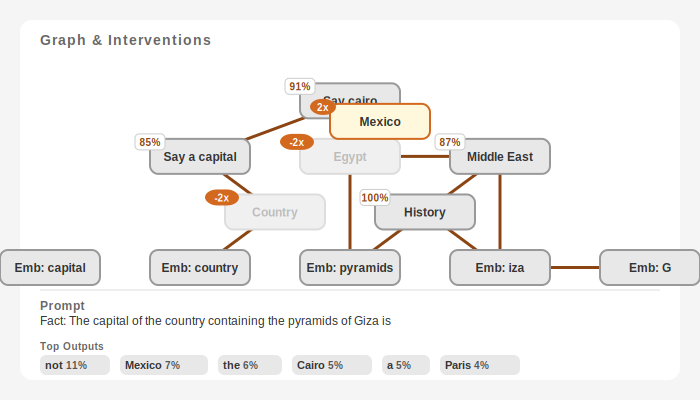

In [85]:
mexico_interventions = [Intervention(country_node, -2), Intervention(egypt_node, -2), Intervention(mexico_node, 2)]
supernode_intervention(cairo_pyramids_graph, mexico_interventions, {egypt_node.name: mexico_node})

## Multilingual Circuits

In this section, we take a look at multilingual circuits, as studied [in the original paper](https://transformer-circuits.pub/2025/attribution-graphs/biology.html#dives-multilingual). 

Specifically, we look at three circuits, for the same sentence in 3 languages:

- English: [`The opposite of "small" is "` → `big`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=large-english&pruningThreshold=0.65&densityThreshold=0.99&pinnedIds=15_7209_2%2C2_6323_2%2CE_13388_2%2C17_12530_5%2C18_9402_8%2C6_4362_5%2C15_5617_5%2CE_10498_5%2C7_10545_5%2C4_12355_5%2C27_13210_8%2C27_7773_8%2C20_3830_8%2C23_8683_8%2C21_10062_8&supernodes=%5B%5B%22say+big%22%2C%2221_10062_8%22%2C%2223_8683_8%22%5D%2C%5B%22small%22%2C%2215_5617_5%22%2C%2217_12530_5%22%2C%224_12355_5%22%5D%2C%5B%22opposite%22%2C%222_6323_2%22%2C%2215_7209_2%22%5D%2C%5B%22size%22%2C%226_4362_5%22%2C%2220_3830_8%22%2C%2218_9402_8%22%5D%2C%5B%22Output+%5C%22large%5C%22+%28p%3D0.420%29%22%2C%2227_13210_8%22%2C%2227_7773_8%22%5D%5D)
- French: [`Le contraire de "petit" est "` → `grand`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=large-french&pruningThreshold=0.65&densityThreshold=0.99&pinnedIds=5_11184_2%2CE_63265_2%2C4_95_2%2C3_11241_2%2C4_15846_2%2CE_64986_5%2C27_21996_8%2C21_10062_8%2C23_2592_8%2C20_1454_8%2C22_12661_8%2C21_11127_8%2C3_2873_5%2C18_9402_8%2C17_1275_5%2C16_7232_5%2C18_9402_8%2C17_6043_5%2C3_12834_5%2C2_14129_5%2C23_8488_8%2C14_11360_5%2C3_1978_5%2C15_5617_5&supernodes=%5B%5B%22french%22%2C%2221_11127_8%22%2C%2223_2592_8%22%2C%2220_1454_8%22%2C%2222_12661_8%22%5D%2C%5B%22size%22%2C%223_2873_5%22%2C%2218_9402_8%22%5D%2C%5B%22opposite%22%2C%225_11184_2%22%2C%224_95_2%22%2C%224_15846_2%22%2C%223_11241_2%22%5D%2C%5B%22small%22%2C%2215_5617_5%22%2C%2214_11360_5%22%2C%223_12834_5%22%2C%2216_7232_5%22%5D%2C%5B%22say+big%22%2C%223_1978_5%22%2C%222_14129_5%22%2C%2223_8488_8%22%2C%2221_10062_8%22%2C%2217_6043_5%22%2C%2217_1275_5%22%5D%5D)
- Chinese: [`"小"的反义词是"` → `大`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=large-chinese&pruningThreshold=0.65&densityThreshold=0.99&pinnedIds=E_235585_2%2C23_8488_8%2C23_8683_8%2C21_10062_8%2C19_1435_2%2CE_236711_5%2CE_235427_7%2C17_12530_2%2C20_3830_8%2C20_7783_8%2C6_1947_2%2C16_7232_2%2C16_9788_2%2C6_1947_4%2C4_15846_5%2C4_7409_6%2CE_208659_4%2C2_10582_4%2C1_7065_4%2C1_16015_4%2C4_1798_4%2C0_4052_6%2CE_237379_6%2C15_5617_3%2C7_10545_3%2C8_8276_3%2C1_16015_3%2C1_8274_3%2C1_1806_3%2C1_750_3%2C18_9402_8%2C15_5617_2%2C19_8658_8%2C14_11360_2%2C6_1947_2%2C27_235469_8%2C22_11933_8%2C21_9377_8%2C24_2394_8&supernodes=%5B%5B%22say+large+in+chinese%22%2C%2221_10062_8%22%2C%2219_8658_8%22%2C%2223_8683_8%22%2C%2223_8488_8%22%2C%2221_9377_8%22%5D%2C%5B%22small%22%2C%2215_5617_3%22%2C%2219_1435_2%22%2C%2217_12530_2%22%2C%2216_7232_2%22%2C%2215_5617_2%22%2C%2214_11360_2%22%5D%2C%5B%22size%22%2C%228_8276_3%22%2C%2216_9788_2%22%2C%2218_9402_8%22%2C%2220_3830_8%22%5D%2C%5B%22comparisons%22%2C%224_7409_6%22%2C%227_10545_3%22%2C%224_15846_5%22%5D%2C%5B%22chinese%22%2C%220_4052_6%22%2C%2224_2394_8%22%2C%2220_7783_8%22%2C%2222_11933_8%22%2C%224_1798_4%22%2C%226_1947_4%22%2C%221_16015_3%22%2C%221_1806_3%22%2C%221_8274_3%22%2C%221_16015_4%22%2C%221_7065_4%22%2C%226_1947_2%22%2C%221_750_3%22%2C%222_10582_4%22%5D%5D)

Work on Haiku showed one shared [multilingual circuit](https://transformer-circuits.pub/2025/attribution-graphs/biology.html#dives-multilingual): 

Our circuits show the same behavior. In fact, unlike the Haiku circuits, the Gemma 2 (2B) circuits are essentially entirely multilingual. There are no individual "Say big" or "Say grand" supernodes that cause the model to output a specific answer in a specific language. Instead, all circuits use "Say big" features, combined with a "French" or "Chinese" feature if the answer is non-English. This is largely in-line with Anthropic's findings that, while there are multilingual features, Gemma 2B appears to default to English for its output.

Let's study these simple circuits by performing interventions on them. First, we'll create Supernode objects:

In [66]:
url_fr = 'https://www.neuronpedia.org/gemma-2-2b/graph?slug=large-french&pruningThreshold=0.65&densityThreshold=0.99&pinnedIds=5_11184_2%2CE_63265_2%2C4_95_2%2C3_11241_2%2C4_15846_2%2CE_64986_5%2C27_21996_8%2C21_10062_8%2C23_2592_8%2C20_1454_8%2C22_12661_8%2C21_11127_8%2C3_2873_5%2C18_9402_8%2C17_1275_5%2C16_7232_5%2C18_9402_8%2C17_6043_5%2C3_12834_5%2C2_14129_5%2C23_8488_8%2C14_11360_5%2C3_1978_5%2C15_5617_5&supernodes=%5B%5B%22french%22%2C%2221_11127_8%22%2C%2223_2592_8%22%2C%2220_1454_8%22%2C%2222_12661_8%22%5D%2C%5B%22size%22%2C%223_2873_5%22%2C%2218_9402_8%22%5D%2C%5B%22opposite%22%2C%225_11184_2%22%2C%224_95_2%22%2C%224_15846_2%22%2C%223_11241_2%22%5D%2C%5B%22small%22%2C%2215_5617_5%22%2C%2214_11360_5%22%2C%223_12834_5%22%2C%2216_7232_5%22%5D%2C%5B%22say+big%22%2C%223_1978_5%22%2C%222_14129_5%22%2C%2223_8488_8%22%2C%2221_10062_8%22%2C%2217_6043_5%22%2C%2217_1275_5%22%5D%5D'
supernodes_fr = extract_supernode_features(url_fr)
french_node = Supernode('French', features=supernodes_fr['french'], children=[])
say_big_node = Supernode('Say big', features=supernodes_fr["say big"])
small_node = Supernode('small', features=supernodes_fr['small'], children=[say_big_node])
opposite_node = Supernode('opposite', features=supernodes_fr['opposite'], children=[say_big_node])

url_en = 'https://www.neuronpedia.org/gemma-2-2b/graph?slug=large-english&pruningThreshold=0.65&densityThreshold=0.99&pinnedIds=15_7209_2%2C2_6323_2%2CE_13388_2%2C17_12530_5%2C18_9402_8%2C6_4362_5%2C15_5617_5%2CE_10498_5%2C7_10545_5%2C4_12355_5%2C27_13210_8%2C27_7773_8%2C20_3830_8%2C23_8683_8%2C21_10062_8&supernodes=%5B%5B%22say+big%22%2C%2221_10062_8%22%2C%2223_8683_8%22%5D%2C%5B%22small%22%2C%2215_5617_5%22%2C%2217_12530_5%22%2C%224_12355_5%22%5D%2C%5B%22opposite%22%2C%222_6323_2%22%2C%2215_7209_2%22%5D%2C%5B%22size%22%2C%226_4362_5%22%2C%2220_3830_8%22%2C%2218_9402_8%22%5D%2C%5B%22Output+%5C%22large%5C%22+%28p%3D0.420%29%22%2C%2227_13210_8%22%2C%2227_7773_8%22%5D%5D'
supernodes_en = extract_supernode_features(url_en)
english_say_big_node = Supernode('English Say big', features=supernodes_en['say big'])


url_zh = 'https://www.neuronpedia.org/gemma-2-2b/graph?slug=large-chinese&pruningThreshold=0.65&densityThreshold=0.99&pinnedIds=E_235585_2%2C23_8488_8%2C23_8683_8%2C21_10062_8%2C19_1435_2%2CE_236711_5%2CE_235427_7%2C17_12530_2%2C20_3830_8%2C20_7783_8%2C6_1947_2%2C16_7232_2%2C16_9788_2%2C6_1947_4%2C4_15846_5%2C4_7409_6%2CE_208659_4%2C2_10582_4%2C1_7065_4%2C1_16015_4%2C4_1798_4%2C0_4052_6%2CE_237379_6%2C15_5617_3%2C7_10545_3%2C8_8276_3%2C1_16015_3%2C1_8274_3%2C1_1806_3%2C1_750_3%2C18_9402_8%2C15_5617_2%2C19_8658_8%2C14_11360_2%2C6_1947_2%2C27_235469_8%2C22_11933_8%2C21_9377_8%2C24_2394_8&supernodes=%5B%5B%22say+large+in+chinese%22%2C%2221_10062_8%22%2C%2219_8658_8%22%2C%2223_8683_8%22%2C%2223_8488_8%22%2C%2221_9377_8%22%5D%2C%5B%22small%22%2C%2215_5617_3%22%2C%2219_1435_2%22%2C%2217_12530_2%22%2C%2216_7232_2%22%2C%2215_5617_2%22%2C%2214_11360_2%22%5D%2C%5B%22size%22%2C%228_8276_3%22%2C%2216_9788_2%22%2C%2218_9402_8%22%2C%2220_3830_8%22%5D%2C%5B%22comparisons%22%2C%224_7409_6%22%2C%227_10545_3%22%2C%224_15846_5%22%5D%2C%5B%22chinese%22%2C%220_4052_6%22%2C%2224_2394_8%22%2C%2220_7783_8%22%2C%2222_11933_8%22%2C%224_1798_4%22%2C%226_1947_4%22%2C%221_16015_3%22%2C%221_1806_3%22%2C%221_8274_3%22%2C%221_16015_4%22%2C%221_7065_4%22%2C%226_1947_2%22%2C%221_750_3%22%2C%222_10582_4%22%5D%5D'
supernodes_zh = extract_supernode_features(url_zh)
chinese_node = Supernode('Chinese', features=supernodes_zh['chinese'], children=[])

ordered_nodes_fr = [[french_node, opposite_node, small_node], [say_big_node]]

prompt_en = 'The opposite of "small" is "'
prompt_fr = 'Le contraire de "petit" est "'
prompt_zh = '"小"的反义词是"'

small_big_graph = InterventionGraph(ordered_nodes=ordered_nodes_fr, prompt=prompt_fr)

Then, we get the activations for these nodes, initialize them, and create a visualization.

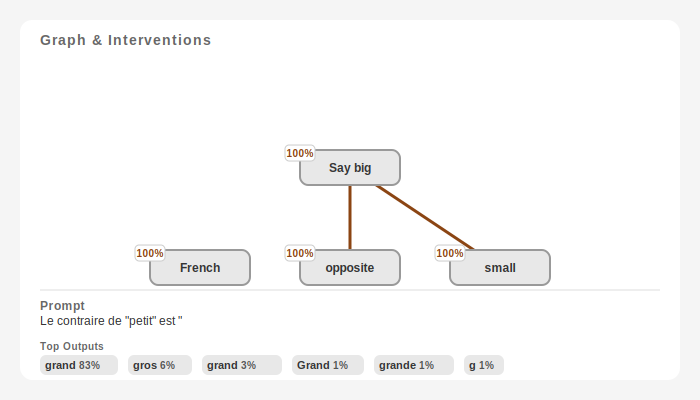

In [89]:
logits_fr, activations_fr = model.get_activations(prompt_fr)

for node in [say_big_node, small_node, french_node, opposite_node]:
    small_big_graph.initialize_node(node, activations_fr)

logits_zh, activations_zh = model.get_activations(prompt_zh)
small_big_graph.initialize_node(chinese_node, activations_zh)

logits_en, activations_en = model.get_activations(prompt_en)
small_big_graph.initialize_node(english_say_big_node, activations_en)

small_big_graph.set_node_activation_fractions(activations_fr)
create_graph_visualization(small_big_graph, get_top_outputs(logits_fr))

Then we performed our first intervention: we'll turn off the French supernode.

Strongly turning off the "French" supernode (-3x) produces the desired effect - the most likely output is 'big' followed by 'great' with little effect on the model wanting to 'Say big'. 

The likelihood of producing "grande" progressively reduces as ablations get stronger, while the likelihood of producing "big" progressively increases.

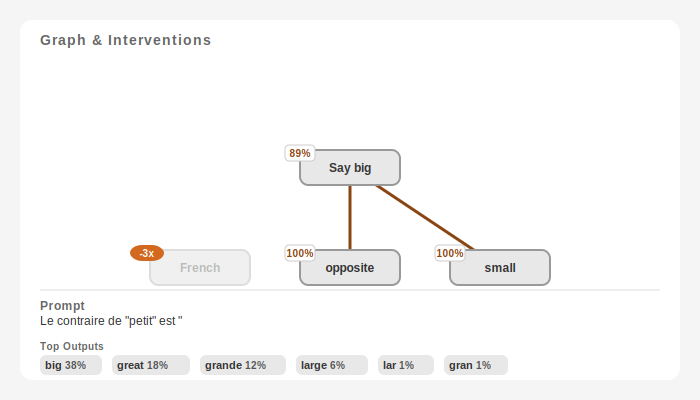

In [96]:
french_to_english_interventions = [Intervention(french_node, -3)]
supernode_intervention(small_big_graph, french_to_english_interventions)

To confirm that the key difference is the "French" supernode, we patch in the "English Say big" supernode from the English only tree, then very strongly increase this supernode (10x) and very strongly decrease the "Say big" supernode on the original French tree.

With a radically English tree the top output is now 'grand', an English word but very *French*, 'big' does not make it to our top 6 outputs.

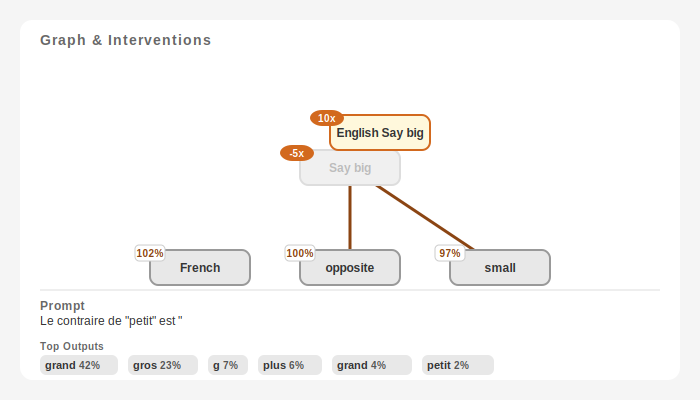

In [ ]:
french_english_plus_intervention = [Intervention(say_big_node, -5), Intervention(english_say_big_node, 10)]
supernode_intervention(small_big_graph, french_english_plus_intervention, replacements={say_big_node.name: english_say_big_node})

Now, let's try to change the language to another: we'll turn off the French supernode, and turn on the Chinese supernode.

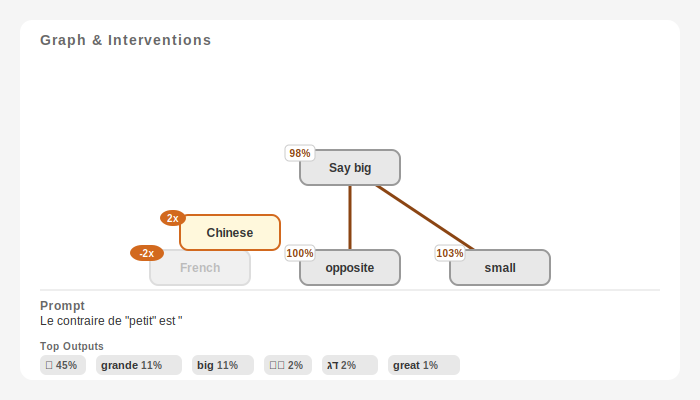

In [58]:
french_to_chinese_interventions = [Intervention(french_node, -2), Intervention(chinese_node, 2)]
supernode_intervention(small_big_graph, french_to_chinese_interventions, replacements={french_node.name: chinese_node})

As expected, the model's output post-intervention is identical to its original output on the Chinese example!

## Appendix

### Circuits


### Related papers


<head>
    <style>
        body {
            margin: 20px;
            font-family: Arial, sans-serif;
            background-color: #f5f5f5;
        }
        
        .container {
            background: white;
            border-radius: 12px;
            padding: 20px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
            max-width: 900px;
            margin: 0 auto;
        }
        
        .title {
            font-size: 18px;
            font-weight: bold;
            color: #666;
            margin-bottom: 20px;
            text-transform: uppercase;
            letter-spacing: 1px;
        }
        
        .graph-container {
            position: relative;
            height: 400px;
            margin: 20px 0;
            overflow: visible;
        }
        
        .node {
            position: absolute;
            background: #e8e8e8;
            border: 2px solid #999;
            border-radius: 8px;
            padding: 12px 16px;
            font-weight: bold;
            color: #333;
            text-align: center;
            cursor: pointer;
            transition: all 0.3s ease;
            min-width: 80px;
            box-sizing: border-box;
        }
        
        .node.low-activation {
            background: #f0f0f0;
            color: #bbb;
            border-color: #ddd;
        }
        
        .node.replacement {
            border: 2px solid #D2691E;
            background: #FFF8DC;
        }
        
        .node:hover {
            transform: translateY(-2px);
            box-shadow: 0 4px 12px rgba(0,0,0,0.2);
        }
        
        .activation-label {
            position: absolute;
            font-size: 12px;
            font-weight: bold;
            color: #8B4513;
            background: white;
            padding: 2px 6px;
            border-radius: 4px;
            border: 1px solid #ccc;
            white-space: nowrap;
        }
        
        .intervention {
            position: absolute;
            background: #D2691E;
            color: white;
            border-radius: 12px;
            padding: 4px 12px;
            font-size: 12px;
            font-weight: bold;
            white-space: nowrap;
        }
        
        .connection {
            position: absolute;
            background: #8B4513;
            height: 3px;
            transform-origin: left center;
        }
        
        .connection.replacement {
            background: #D2691E;
            height: 4px;
        }
        
        .arrow {
            position: absolute;
            width: 0;
            height: 0;
            border-left: 8px solid #8B4513;
            border-top: 5px solid transparent;
            border-bottom: 5px solid transparent;
        }
        
        .arrow.replacement {
            border-left-color: #D2691E;
        }
        
        .prompt-section {
            margin-top: 30px;
            padding-top: 20px;
            border-top: 1px solid #ddd;
        }
        
        .prompt-title {
            font-size: 16px;
            font-weight: bold;
            color: #666;
            margin-bottom: 10px;
            text-transform: uppercase;
            letter-spacing: 0.5px;
        }
        
        .prompt-text {
            font-size: 16px;
            line-height: 1.5;
            margin-bottom: 20px;
        }
        
        .outputs-section {
            margin-top: 20px;
        }
        
        .outputs-title {
            font-size: 14px;
            font-weight: bold;
            color: #666;
            margin-bottom: 15px;
            text-transform: uppercase;
            letter-spacing: 0.5px;
        }
        
        .output-items {
            display: flex;
            flex-wrap: wrap;
            gap: 10px;
        }
        
        .output-item {
            background: #e8e8e8;
            padding: 6px 12px;
            border-radius: 6px;
            font-weight: bold;
            display: flex;
            align-items: center;
            gap: 8px;
        }
        
        .output-percentage {
            font-size: 12px;
            color: #666;
        }
    </style>
</head>
<body>
    <div class="container">
        <div class="title">Graph & Interventions</div>
        
        <div class="graph-container" id="graphContainer">
            <!-- Supernodes and connections will be positioned here -->
        </div>
        
        <div class="prompt-section">
            <div class="prompt-title">Prompt</div>
            <div class="prompt-text" id="promptText">
                <!-- Prompt will be inserted here -->
            </div>
            
            <div class="outputs-section">
                <div class="outputs-title">Top Outputs</div>
                <div class="output-items" id="outputItems">
                    <!-- Output items will be inserted here -->
                </div>
            </div>
        </div>
    </div>

    <script>
        // Configuration - can be modified
        const prompt = "Fact: the capital of the state containing Dallas is";
        const top_outputs = [["Sacramento", 0.97], ["", 0.007], ["not", 0.004], ["the", 0.003], ["⏎", 0.003], ["()", 0.002]];
        
        // Supernode layout configuration (base nodes only - replacements will be positioned automatically)
        const nodes = [
            ['capital', 'state', 'Dallas'],
            ['Say a capital', 'Texas'], 
            ['Say Austin']
        ];
        
        // Supernode properties (without x,y coordinates)
        const nodeProperties = {
            'capital': { activation: 1.0 },
            'state': { activation: 1.0 },
            'Dallas': { activation: 1.0 },
            'Say a capital': { activation: 0.91 },
            'Texas': { activation: null, intervention: '-2x', replacement_node: 'California' },
            'Say Austin': { activation: 0.0, replacement_node: 'Say Sacramento' },
            'California': { activation: null, intervention: '+2x', children: ['Say Sacramento'] },
            'Say Sacramento': { activation: null }
        };

        // Connection data - includes both original and replacement connections
        const connections = [
            { from: 'capital', to: 'Say a capital' },
            { from: 'state', to: 'Say a capital' },
            { from: 'state', to: 'Texas' },
            { from: 'Dallas', to: 'Texas' },
            { from: 'Say a capital', to: 'Say Austin' },
            { from: 'Texas', to: 'Say Austin', replacement: true }, // This gets replaced
            { from: 'California', to: 'Say Sacramento', replacement: true }
        ];

        // Auto-calculate positions based on node layout
        function calculateSupernodePositions() {
            const containerWidth = 800;
            const containerHeight = 350;
            const nodeWidth = 120;
            const nodeHeight = 40;
            
            const nodeData = {};
            
            // First, position the base nodes from the layout
            for (let rowIndex = 0; rowIndex < nodes.length; rowIndex++) {
                const row = nodes[rowIndex];
                const rowY = containerHeight - (rowIndex * (containerHeight / (nodes.length + 0.5)));
                
                for (let colIndex = 0; colIndex < row.length; colIndex++) {
                    const nodeName = row[colIndex];
                    const rowWidth = row.length * nodeWidth + (row.length - 1) * 50;
                    const startX = (containerWidth - rowWidth) / 2;
                    const nodeX = startX + colIndex * (nodeWidth + 50);
                    
                    nodeData[nodeName] = {
                        x: nodeX,
                        y: rowY,
                        ...nodeProperties[nodeName]
                    };
                }
            }
            
            // Then, position replacement nodes directly above their original nodes (with slight offset)
            Object.keys(nodeProperties).forEach(nodeName => {
                const nodeProps = nodeProperties[nodeName];
                if (nodeProps.replacement_node && !nodeData[nodeProps.replacement_node]) {
                    const originalSupernode = nodeData[nodeName];
                    if (originalSupernode) {
                        // Position replacement node directly above with small right offset, touching the original
                        nodeData[nodeProps.replacement_node] = {
                            x: originalSupernode.x + 30,
                            y: originalSupernode.y - 35,
                            ...nodeProperties[nodeProps.replacement_node]
                        };
                    }
                }
            });
            
            return nodeData;
        }
        
        // Calculate positions
        const nodeData = calculateSupernodePositions();

        function getSupernodeCenter(nodeName) {
            const node = nodeData[nodeName];
            if (!node) return { x: 0, y: 0 };
            return {
                x: node.x + 60, // Approximate center of node
                y: node.y + 20
            };
        }

        function createConnections() {
            const container = document.getElementById('graphContainer');
            
            connections.forEach(conn => {
                // Skip connections where the 'from' node has a replacement and this isn't a replacement connection
                const fromSupernodeProps = nodeProperties[conn.from];
                if (fromSupernodeProps && fromSupernodeProps.replacement_node && !conn.replacement) {
                    return; // Skip this connection as it's replaced
                }
                
                const fromCenter = getSupernodeCenter(conn.from);
                const toCenter = getSupernodeCenter(conn.to);
                
                if (fromCenter.x === 0 || toCenter.x === 0) return; // Skip if node doesn't exist
                
                const dx = toCenter.x - fromCenter.x;
                const dy = toCenter.y - fromCenter.y;
                const length = Math.sqrt(dx * dx + dy * dy);
                const angle = Math.atan2(dy, dx) * 180 / Math.PI;
                
                // Create connection line
                const line = document.createElement('div');
                line.className = conn.replacement ? 'connection replacement' : 'connection';
                line.style.left = fromCenter.x + 'px';
                line.style.top = fromCenter.y + 'px';
                line.style.width = length + 'px';
                line.style.transform = `rotate(${angle}deg)`;
                container.appendChild(line);
                
                // Create arrow at the end of the line
                const arrowX = toCenter.x - 8;
                const arrowY = toCenter.y - 5;
                
                const arrow = document.createElement('div');
                arrow.className = conn.replacement ? 'arrow replacement' : 'arrow';
                arrow.style.left = arrowX + 'px';
                arrow.style.top = arrowY + 'px';
                container.appendChild(arrow);
            });
        }

        function createSupernodes() {
            const container = document.getElementById('graphContainer');

            // Create nodes
            Object.entries(nodeData).forEach(([name, data]) => {
                const node = document.createElement('div');
                node.className = 'node';
                
                // Check if node should be grayed out (low activation or negative intervention)
                const isLowActivation = data.activation !== null && data.activation <= 0.25;
                const hasNegativeIntervention = data.intervention && data.intervention.includes('-');
                
                if (isLowActivation || hasNegativeIntervention) {
                    node.classList.add('low-activation');
                }
                
                // Check if this is a replacement node
                const isReplacement = Object.values(nodeProperties).some(props => 
                    props.replacement_node === name
                );
                if (isReplacement) {
                    node.classList.add('replacement');
                }
                
                node.textContent = name;
                node.style.left = data.x + 'px';
                node.style.top = data.y + 'px';
                container.appendChild(node);

                // Add activation label if exists (top-left of node)
                if (data.activation !== null) {
                    const label = document.createElement('div');
                    label.className = 'activation-label';
                    label.textContent = Math.round(data.activation * 100) + '%';
                    
                    label.style.left = (data.x - 15) + 'px';
                    label.style.top = (data.y - 10) + 'px';
                    container.appendChild(label);
                }

                // Add intervention on top-left of node if exists
                if (data.intervention) {
                    const intervention = document.createElement('div');
                    intervention.className = 'intervention';
                    intervention.textContent = data.intervention;
                    intervention.style.left = (data.x - 20) + 'px';
                    intervention.style.top = (data.y - 10) + 'px';
                    container.appendChild(intervention);
                }
            });
        }

        function createPromptSection() {
            // Set prompt text
            document.getElementById('promptText').innerHTML = `<strong>Fact:</strong> ${prompt.replace('Fact: ', '')}`;
            
            // Create output items
            const outputContainer = document.getElementById('outputItems');
            top_outputs.forEach(([text, percentage]) => {
                const item = document.createElement('div');
                item.className = 'output-item';
                
                if (text === '') {
                    item.innerHTML = `<span class="output-percentage">${Math.round(percentage * 100)}%</span>`;
                } else {
                    item.innerHTML = `${text} <span class="output-percentage">${Math.round(percentage * 100)}%</span>`;
                }
                
                outputContainer.appendChild(item);
            });
        }

        // Initialize the graph
        createConnections();
        createSupernodes();
        createPromptSection();
    </script>
</body>